In [1]:
import mlflow

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch

mpl.rcParams['figure.figsize'] = (16, 40)
mpl.rcParams['axes.grid'] = False

/Users/mufin/opt/anaconda3/envs/mlflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/full.csv', index_col=0)
df.head()

,Lộ 173 | P,Lộ 173 | Q,Lộ Tổng | P,Lộ Tổng | Q,Lộ 331 | U,Lộ 331 | P,Lộ 331 | Q,Lộ XT371 | P,Lộ XT371 | Q,Lộ XT375 | P,...,PMAI 1 | P điểm bán điện,PMAI 1 | Điện áp thanh cái,PMAI 3 | P đầu cực máy phát,PMAI 3 | Q đầu cực máy phát,PMAI 3 | P điểm bán điện,PMAI 3 | Điện áp thanh cái,DG N.Hoi | P đầu cực máy phát,DG N.Hoi | Q đầu cực máy phát,DG N.Hoi | P điểm bán điện,DG N.Hoi | Điện áp thanh cái
2022-01-01 00:00:00,-93.142471,21.849880,-17.354407,2.423065,37.281559,-3.177847,0.129546,0.245371,-0.027511,-3.462612,...,19.6,119.0,20.1,0.0,20.0,118,23.35738,0.0,23.18476,118.516667
2022-01-01 00:30:00,-99.621262,23.681150,-17.651513,2.323327,37.233410,-3.181973,0.125267,0.211125,-0.027719,-3.452139,...,19.9,118.0,20.5,0.0,20.4,118,23.49320,0.0,23.31954,118.516667
2022-01-01 01:00:00,-100.208397,24.061800,-17.063483,2.421932,37.233891,-2.807933,0.209686,0.554362,0.077991,-3.445175,...,18.9,118.0,20.3,0.0,20.2,118,23.20566,0.0,23.03432,118.883333
2022-01-01 01:30:00,-98.068352,23.737160,-17.180022,2.419002,37.246571,-3.095382,0.162589,0.363134,0.019717,-3.455763,...,18.6,118.0,19.1,0.0,19.0,118,22.78034,0.0,22.61132,118.883333
2022-01-01 02:00:00,-95.622337,22.264839,-17.341995,2.497786,37.340401,-3.346495,0.092832,0.000000,0.000000,-3.460487,...,19.3,119.0,20.1,0.0,20.0,119,22.76314,0.0,22.59640,118.900000


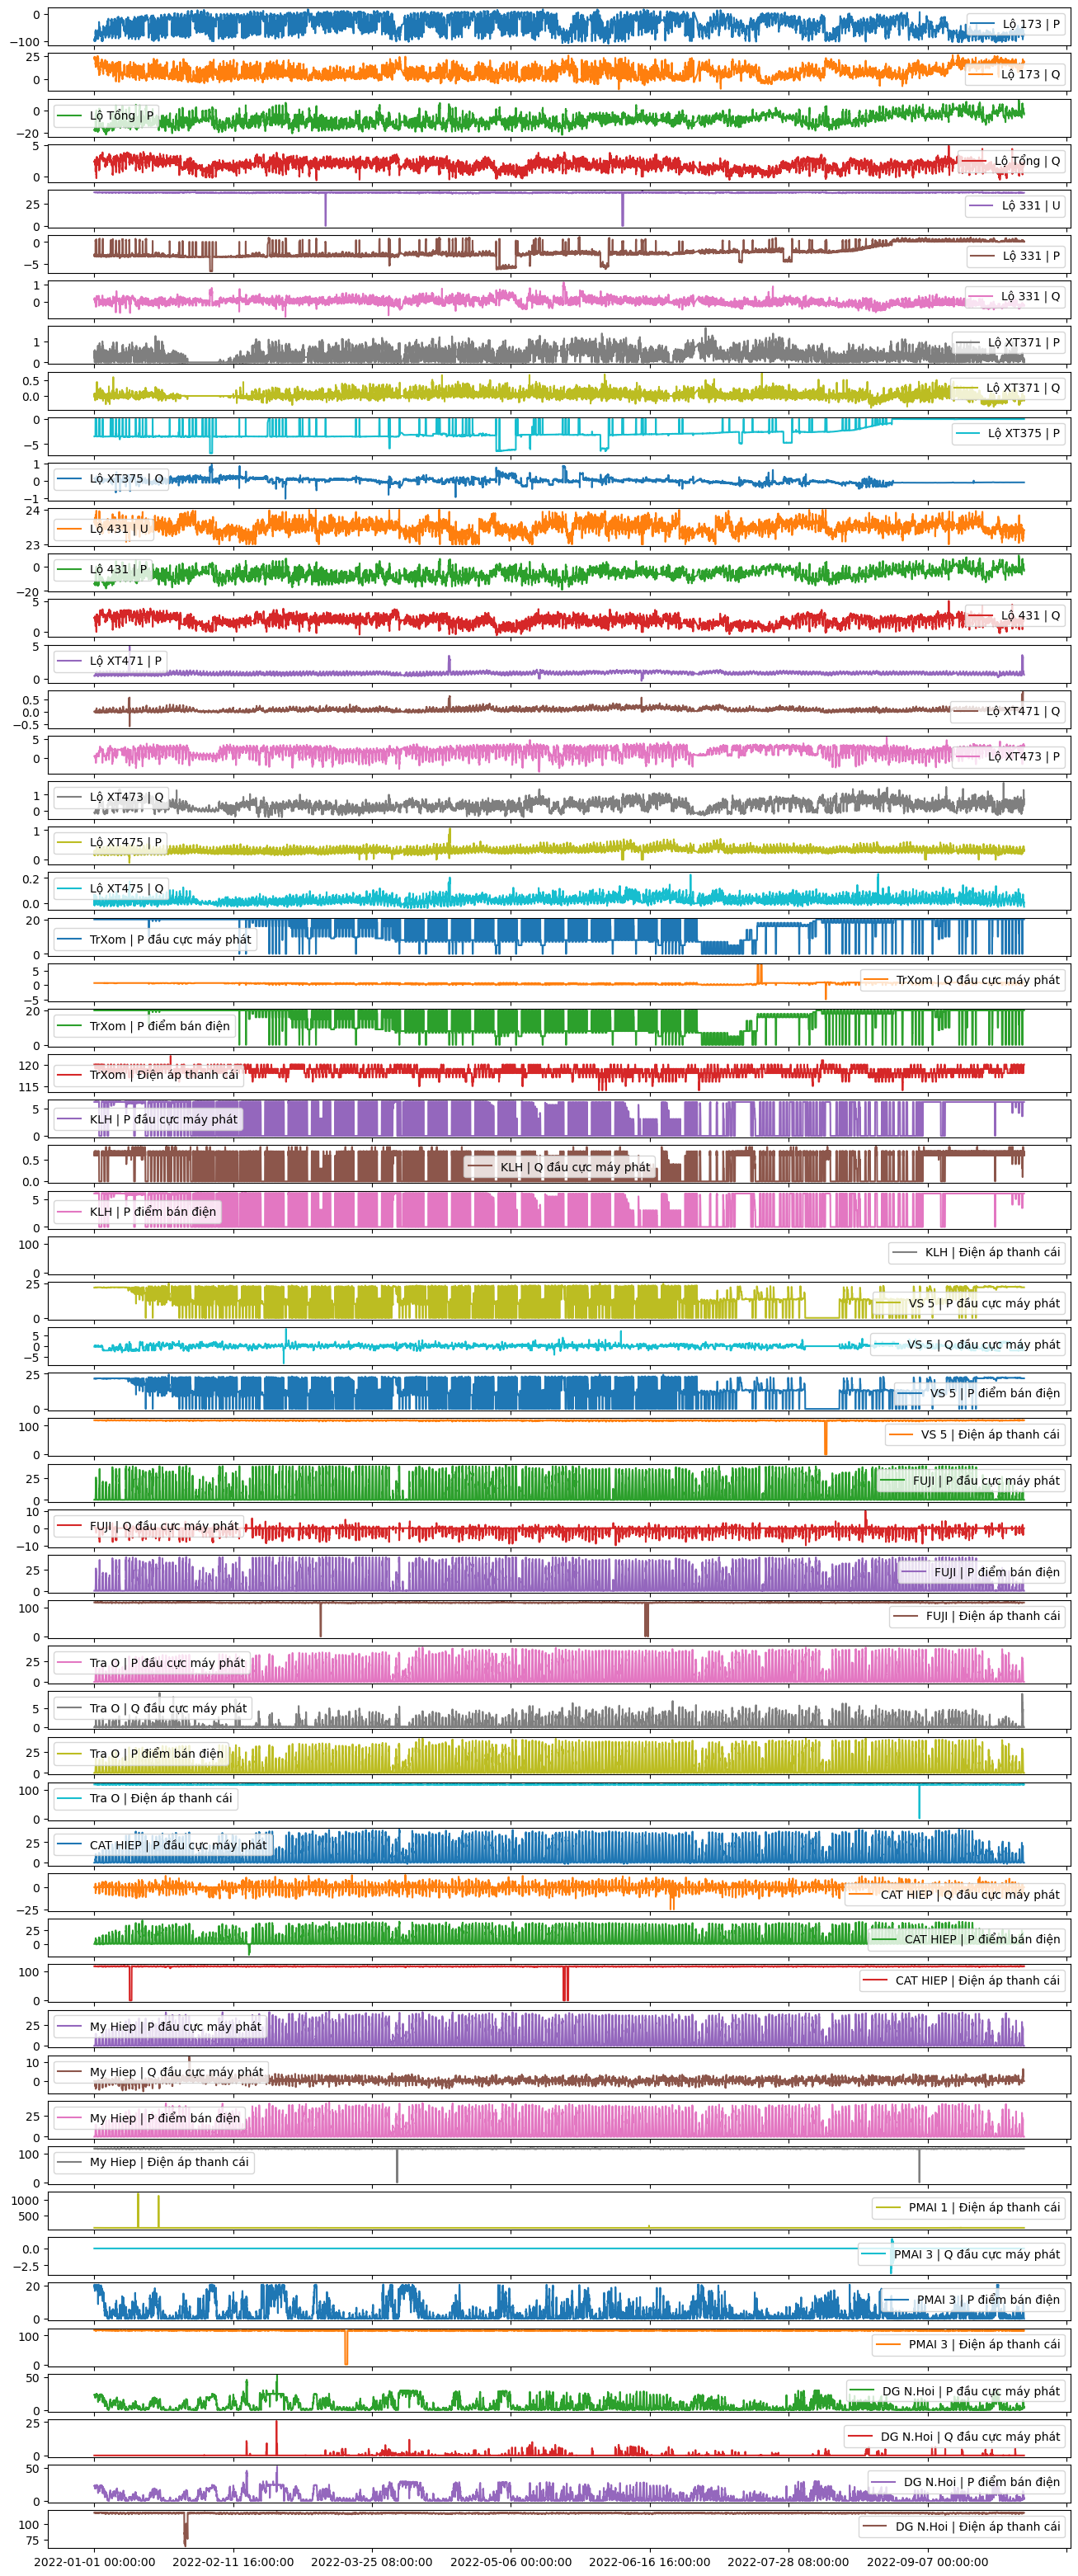

In [3]:
df.plot(subplots=True)
plt.show()

In [4]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, input_cols, target_col, input_horizon, output_horizon):
        total_horizon = input_horizon + output_horizon
        list_features = []
        for col in input_cols:
            if col not in df.columns:
                print(f"Column {col} is not found, skipping.")
                continue
            series = df[col]
            merged_series = pd.concat([series.diff(periods=i) for i in range(total_horizon)], axis=1).dropna()
            inp = np.expand_dims(merged_series.values[:, :input_horizon], 1)
            list_features.append(inp)
            if col == target_col:
                self.tar = merged_series.values[:, -output_horizon:]
                print(self.tar.shape)
        self.inp = np.concatenate(list_features, axis=1)
        print(self.inp.shape)
        
    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        inp = torch.from_numpy(self.inp[idx]).float()
        tar = torch.from_numpy(self.tar[idx]).float()
        return inp, tar

In [5]:
input_horizon = 24
output_horizon = 48
# Randomly choose 3 features with the original one
input_cols=['Lộ 173 | P', 'Lộ 173 | Q']
target_col='Lộ 173 | P'
n_channels = len(input_cols)

single_dataset = TimeSeriesDataset(
    df,
    input_cols=['Lộ 173 | P', 'Lộ 173 | Q'],
    target_col='Lộ 173 | P',
    input_horizon=input_horizon,
    output_horizon=output_horizon
)
train_size = int(0.8 * len(single_dataset))
test_size = len(single_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    single_dataset,
    [train_size, test_size]
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True
)

(13321, 48)
(13321, 2, 24)


In [6]:
def get_historical_attributes(series, input_timesteps, output_timesteps):
    df = pd.DataFrame()
    n_features = input_timesteps + output_timesteps
    for i in range(n_features):
        df[f'lag-{i}'] = series.shift(i)
    df.dropna(inplace=True)
    past_df = df.iloc[:, -input_timesteps:]
    future_df = df.iloc[:, :output_timesteps]
    return past_df, future_df

In [7]:
INPUT_TIMESTEPS = 7
OUTPUT_TIMESTEPS = 3
past_df, future_df = get_historical_attributes(df.iloc[:, 0], INPUT_TIMESTEPS, OUTPUT_TIMESTEPS)

In [8]:
df.iloc[:14, 0]

2022-01-01 00:00:00    -93.142471
2022-01-01 00:30:00    -99.621262
2022-01-01 01:00:00   -100.208397
2022-01-01 01:30:00    -98.068352
2022-01-01 02:00:00    -95.622337
2022-01-01 02:30:00    -96.346550
2022-01-01 03:00:00    -93.864532
2022-01-01 03:30:00    -96.071899
2022-01-01 04:00:00    -92.694878
2022-01-01 04:30:00    -88.651047
2022-01-01 05:00:00    -85.551392
2022-01-01 05:30:00    -89.142464
2022-01-01 06:00:00    -99.752342
2022-01-01 06:30:00   -100.099899
Name: Lộ 173 | P, dtype: float64

In [9]:
past_df, future_df = get_historical_attributes(df.iloc[:, 0], INPUT_TIMESTEPS, OUTPUT_TIMESTEPS)
past_df.head()

,lag-3,lag-4,lag-5,lag-6,lag-7,lag-8,lag-9
2022-01-01 04:30:00,-93.864532,-96.346550,-95.622337,-98.068352,-100.208397,-99.621262,-93.142471
2022-01-01 05:00:00,-96.071899,-93.864532,-96.346550,-95.622337,-98.068352,-100.208397,-99.621262
2022-01-01 05:30:00,-92.694878,-96.071899,-93.864532,-96.346550,-95.622337,-98.068352,-100.208397
2022-01-01 06:00:00,-88.651047,-92.694878,-96.071899,-93.864532,-96.346550,-95.622337,-98.068352
2022-01-01 06:30:00,-85.551392,-88.651047,-92.694878,-96.071899,-93.864532,-96.346550,-95.622337


In [10]:
future_df.head()

,lag-0,lag-1,lag-2
2022-01-01 04:30:00,-88.651047,-92.694878,-96.071899
2022-01-01 05:00:00,-85.551392,-88.651047,-92.694878
2022-01-01 05:30:00,-89.142464,-85.551392,-88.651047
2022-01-01 06:00:00,-99.752342,-89.142464,-85.551392
2022-01-01 06:30:00,-100.099899,-99.752342,-89.142464


In [11]:
class DilatedCNN(torch.nn.Module):
    
    def __init__(self, input_horizon, output_horizon):
        super(DilatedCNN, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels=n_channels,
                out_channels=n_channels * 2,
                kernel_size=2,
                dilation=2,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.Conv1d(
                in_channels=n_channels * 2,
                out_channels=n_channels * 4,
                kernel_size=2,
                dilation=2,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.Conv1d(
                in_channels=n_channels * 4,
                out_channels=n_channels * 8,
                kernel_size=2,
                dilation=2,
                padding=1
            ),
            torch.nn.ReLU()
        )
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(n_channels * 8 * input_horizon, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, output_horizon)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [12]:
from tqdm import tqdm

eval_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_model_multi(model_cls: torch.nn.Module, model_name, epochs=5, **kwargs):
    model = model_cls(**kwargs)
    model.to(device)

    loss_fn = torch.nn.MSELoss()
    metr = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.001
    )

    model.train()
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        loss_records = []
        for sample in tqdm(train_dataloader):
            model.zero_grad()

            inp, tar = sample
            inp, tar = inp.to(device), tar.to(device)
            pred = model.forward(inp)

            loss = loss_fn(pred, tar)
            loss.backward()
            optimizer.step()

            loss_records.append(loss.data.cpu().numpy())

            inp, tar = inp.to("cpu"), tar.to("cpu")

        print("loss: {}".format(sum(loss_records) / len(loss_records)))

    model.eval()
    mae_records = []
    mse_records = []
    for sample in tqdm(test_dataloader):
        model.zero_grad()
        inp, tar = sample
        inp, tar = inp.to(device), tar.to(device)
        pred = model.forward(inp)

        mse = loss_fn(pred, tar)
        mae = metr(pred, tar)

        mse_records.append(mse.data.cpu().numpy())
        mae_records.append(mae.data.cpu().numpy())

        inp, tar = inp.to("cpu"), tar.to("cpu")

    eval_dict[model_name] = dict()
    eval_dict[model_name]['MAE'] = sum(mae_records) / len(mae_records)
    eval_dict[model_name]['MSE'] = sum(mse_records) / len(mse_records)

    model.to("cpu")
    print(eval_dict)
    print('Done')
    return model, eval_dict[model_name]['MAE'], eval_dict[model_name]['MSE']

In [13]:
# Use this if you run mlflow locally
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Use this if you have deployed MLFlow server using docker-compose
# mlflow.set_tracking_uri("http://localhost:7777")
mlflow.set_experiment("electric_forecasting")

2023/05/20 23:18:25 INFO mlflow.tracking.fluent: Experiment with name 'electric_forecasting' does not exist. Creating a new experiment.


<Experiment: artifact_location=('/Users/mufin/Documents/data-science-collection/Topic 12 - '
 'MLFlow/notebooks/mlruns/2'), creation_time=1684599505548, experiment_id='2', last_update_time=1684599505548, lifecycle_stage='active', name='electric_forecasting', tags={}>

In [14]:
with mlflow.start_run(run_name='cnn'):
    model, mae, mse = eval_model_multi(DilatedCNN, 'Dilated CNN for alpha forecasting', epochs=10, input_horizon=input_horizon, output_horizon=output_horizon)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.pytorch.log_model(model, "pt_model")

Epoch 1/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 597.53it/s]


loss: 509.2967134653269
Epoch 2/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 601.19it/s]


loss: 424.0160613303428
Epoch 3/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 606.78it/s]


loss: 404.62548959863796
Epoch 4/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 606.43it/s]


loss: 392.8145981178627
Epoch 5/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 607.95it/s]


loss: 384.78416515041044
Epoch 6/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 601.98it/s]


loss: 380.1681353136584
Epoch 7/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 612.04it/s]


loss: 375.97488696582326
Epoch 8/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 614.07it/s]


loss: 371.6013578695578
Epoch 9/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 591.93it/s]


loss: 367.7430750128027
Epoch 10/10


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:02<00:00, 606.37it/s]


loss: 364.2604684342851


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 1976.33it/s]


{'Dilated CNN for alpha forecasting': {'MAE': 14.503577192386468, 'MSE': 380.5603255768736}}
Done


/Users/mufin/opt/anaconda3/envs/mlflow/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [15]:
dl_iteration = iter(test_dataloader)

In [16]:
sample = next(dl_iteration)

In [17]:
inp, tar = sample
pred = model.forward(inp)

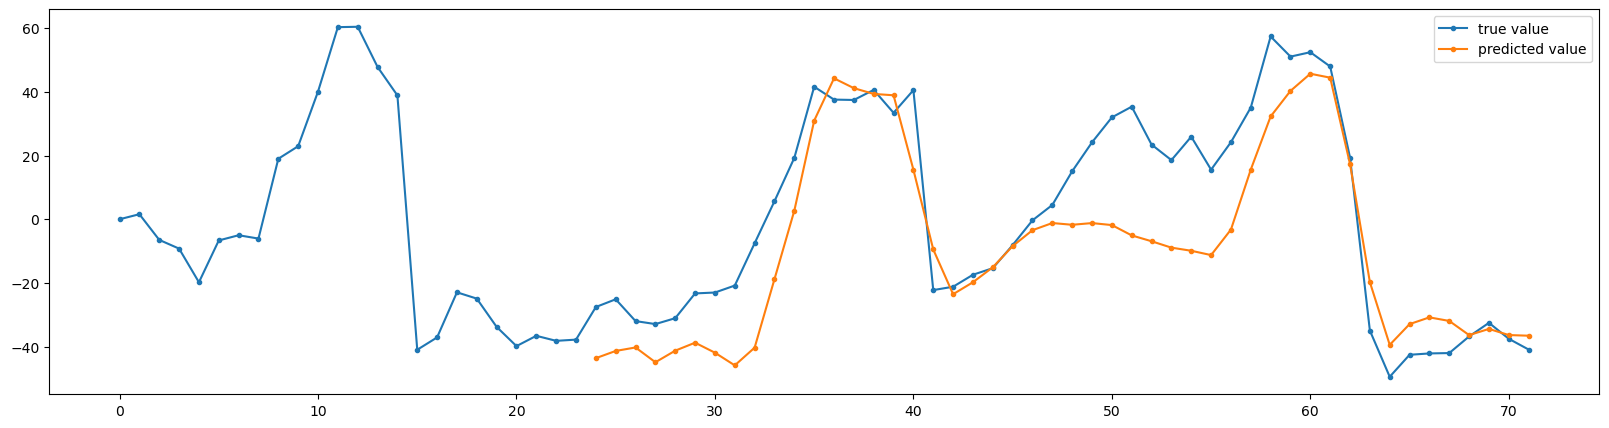

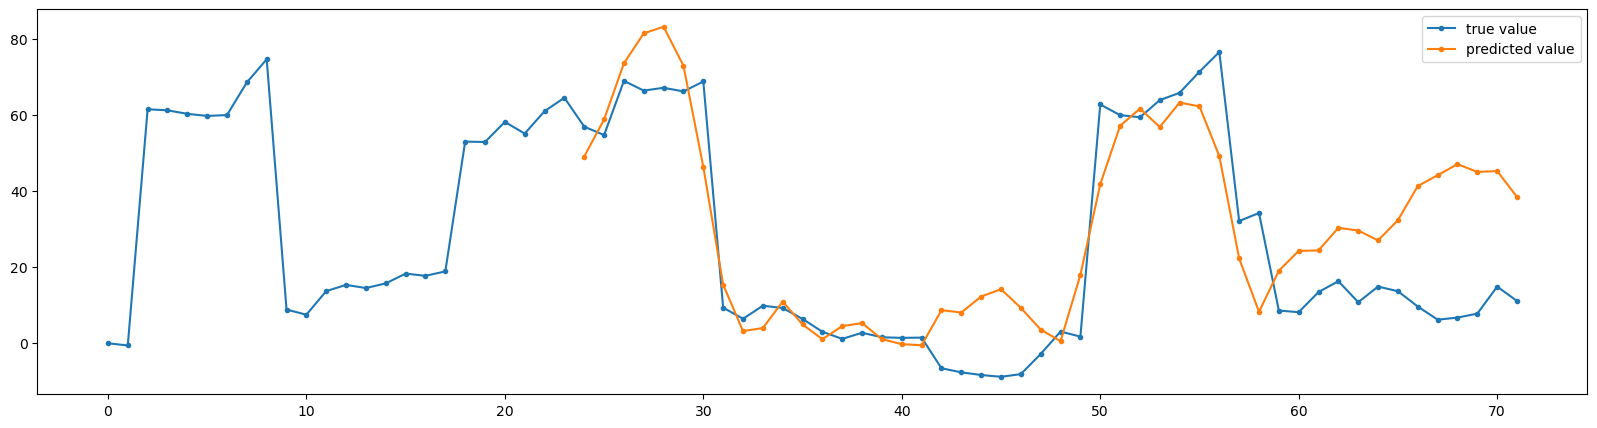

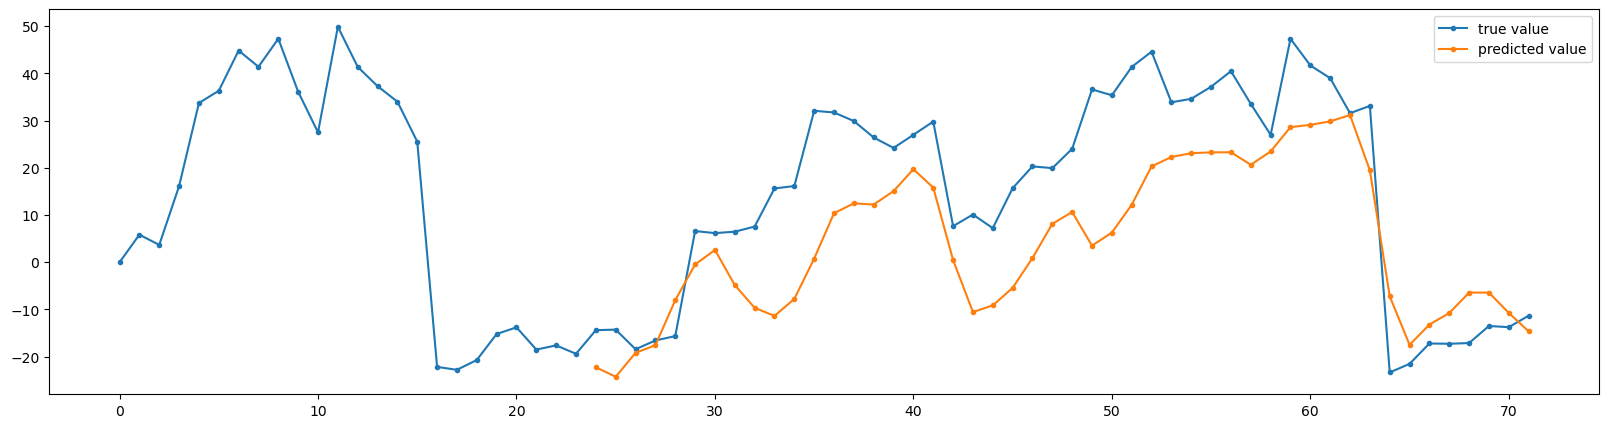

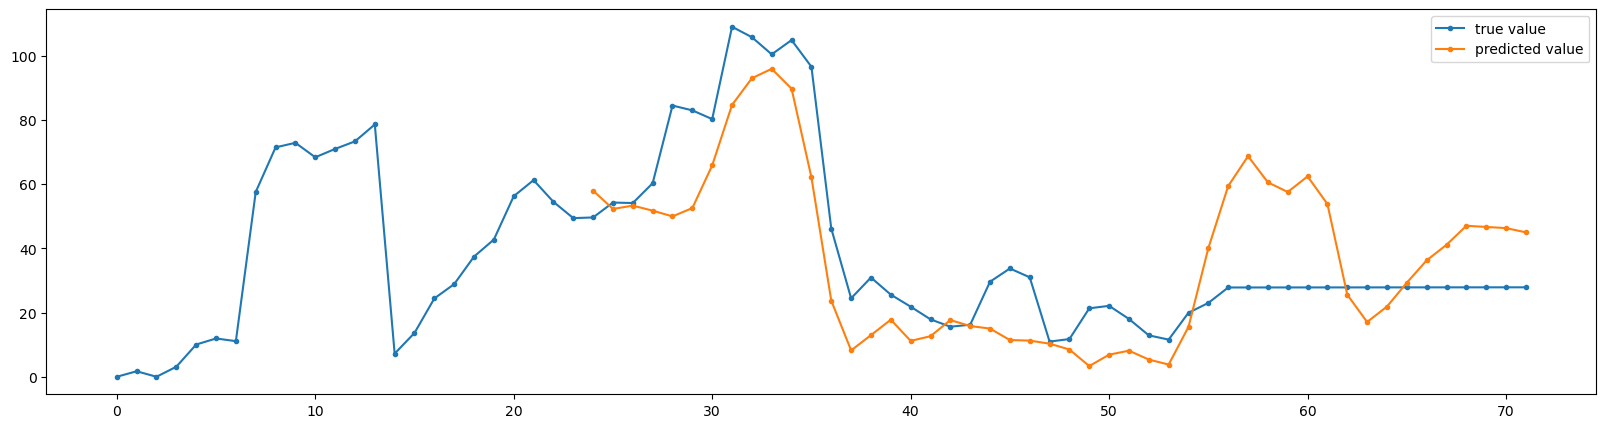

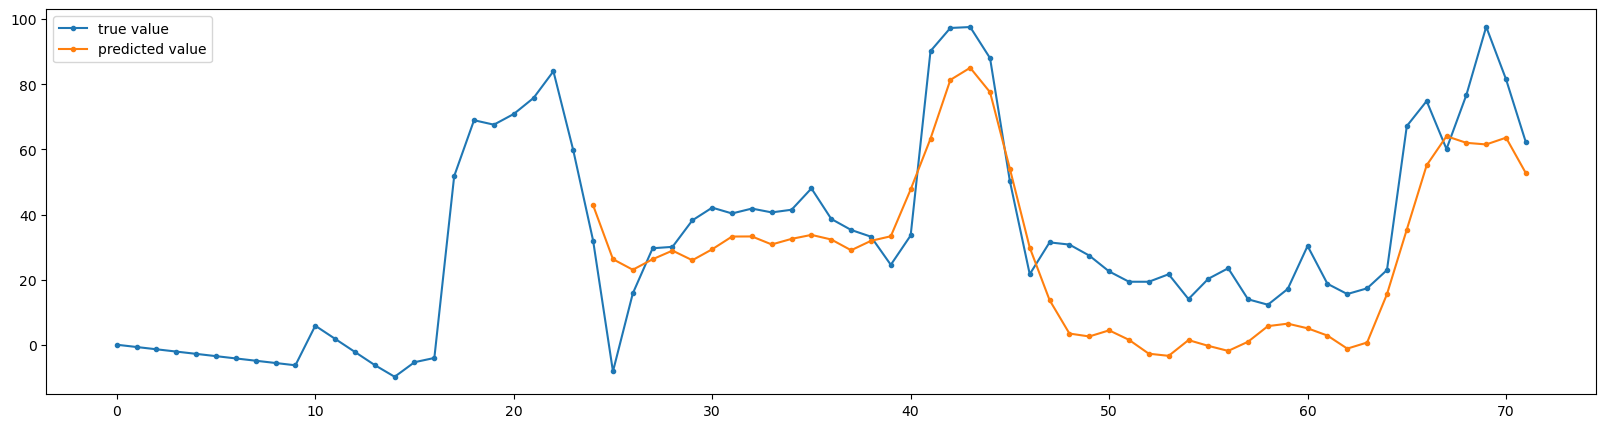

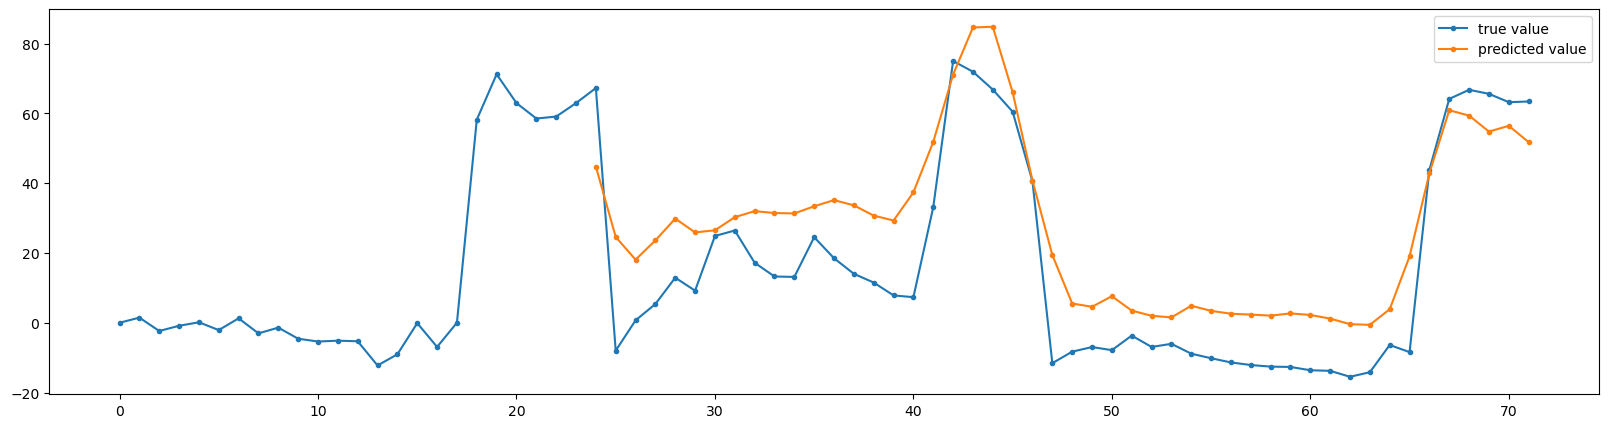

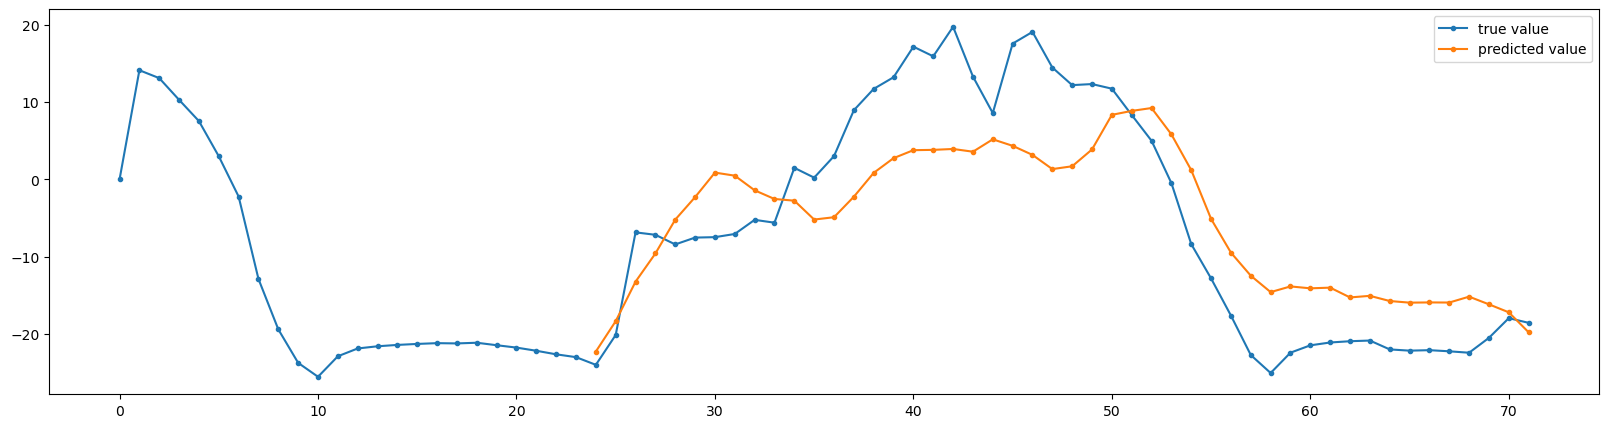

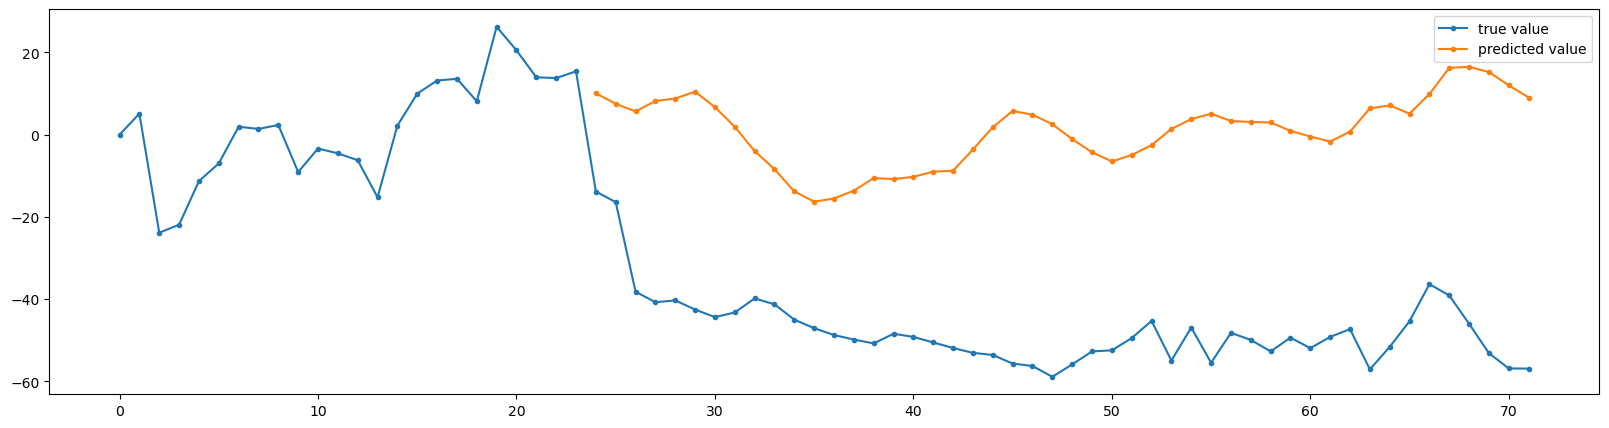

In [18]:
for i, t, p in zip(inp, tar, pred):
    df_1 = pd.DataFrame({
        'true value': i.data.cpu().numpy()[0]
    })
    df_2 = pd.DataFrame({
        'true value': t.data.cpu().numpy(),
        'predicted value': p.data.cpu().numpy()
    })
    df_merged = pd.concat([df_1, df_2], ignore_index=True)
    df_merged.plot(figsize=(20, 5), style='.-')